In [3]:
"""
Created on Sun Feb 12 2022

@author: Kevin Taylor
"""
# computation packages
import numpy as np
import pandas as pd
from math import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from prophet import Prophet


# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from modeling_utils import * # local processing function

In [2]:
weekly_usage = pd.read_csv(
    '../Raw Data/weekly_usage.csv',
    index_col = 0
    ) # read the pre-processed file
weekly_overall = create_kwh_dataframe(weekly_usage) # apply processing function to convert to ts DataFrame
weekly_overall['week'] = weekly_overall.index 
weekly_overall = weekly_overall.groupby('week').mean() # group for all accounts combined, mean usage in kWh

<Figure size 1000x700 with 0 Axes>

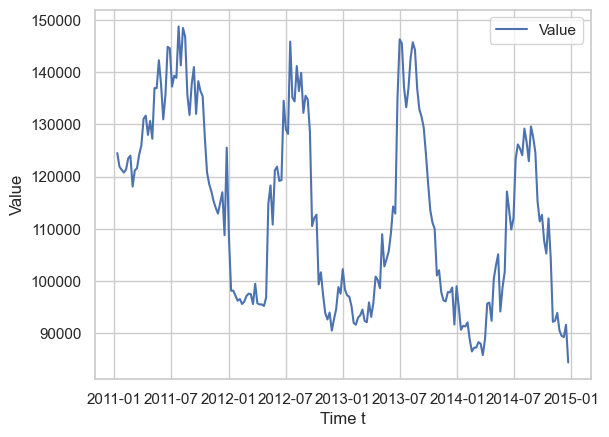

<Figure size 1000x700 with 0 Axes>

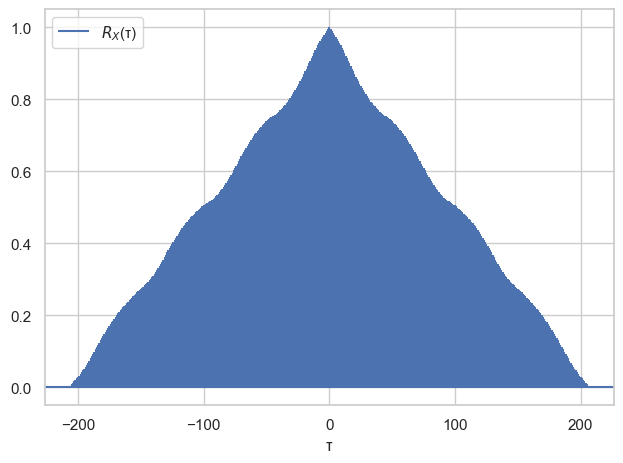

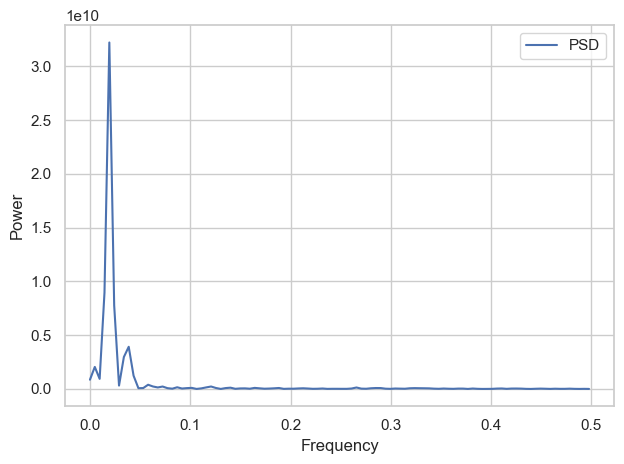

Max Power at period 51.75


In [3]:
ts_plots(weekly_overall, auto_lags = None) # Plot the timeseries, autocorrelation and PSD

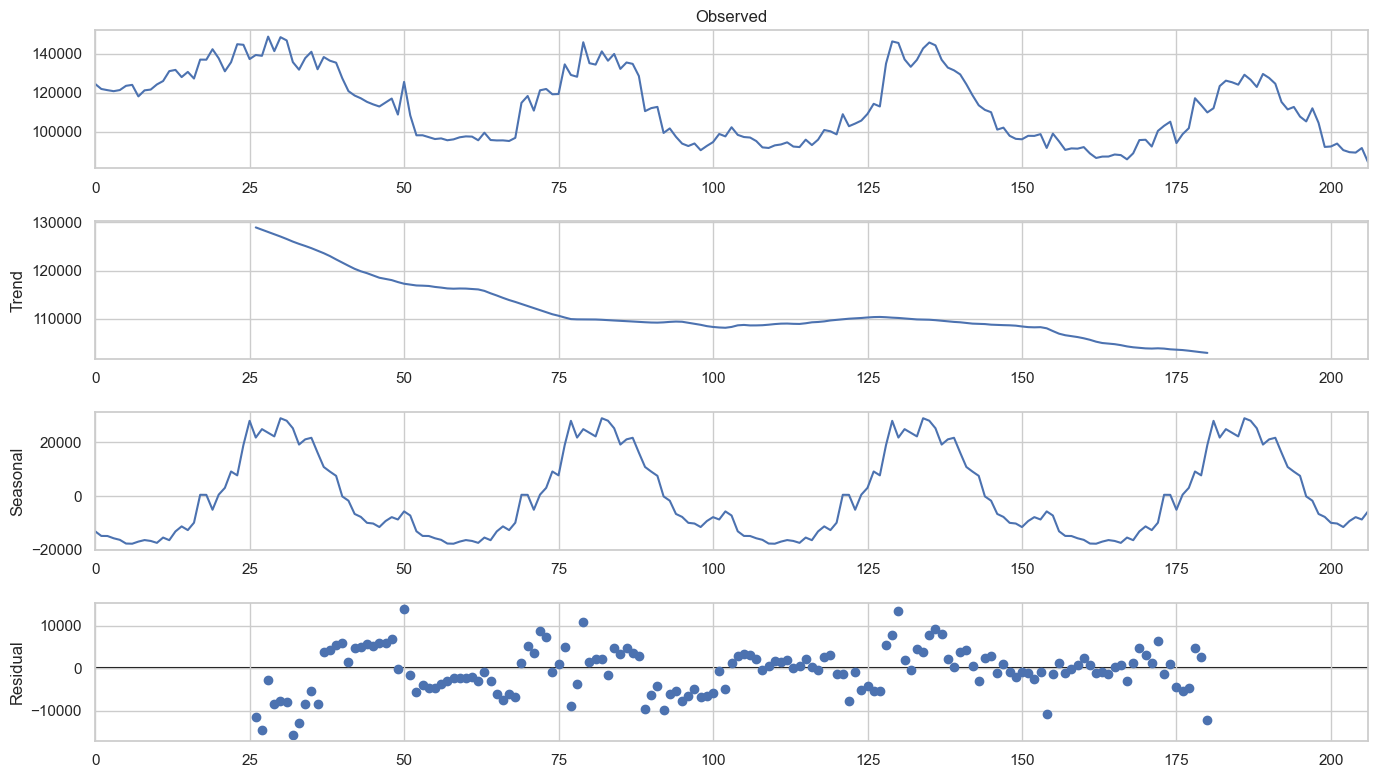

In [4]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=14)
result = seasonal_decompose(weekly_overall.value.values, period = 52, model='additive') # seasonal decomposition of overall ts
fig = result.plot()
# Appears to have 1st order trend with seasonal component, period of 52

In [5]:
######################################################
# SARIMA regression by account - (0, 1, 1)x(0, 1, 1) #
######################################################

MAPE = 12.79%


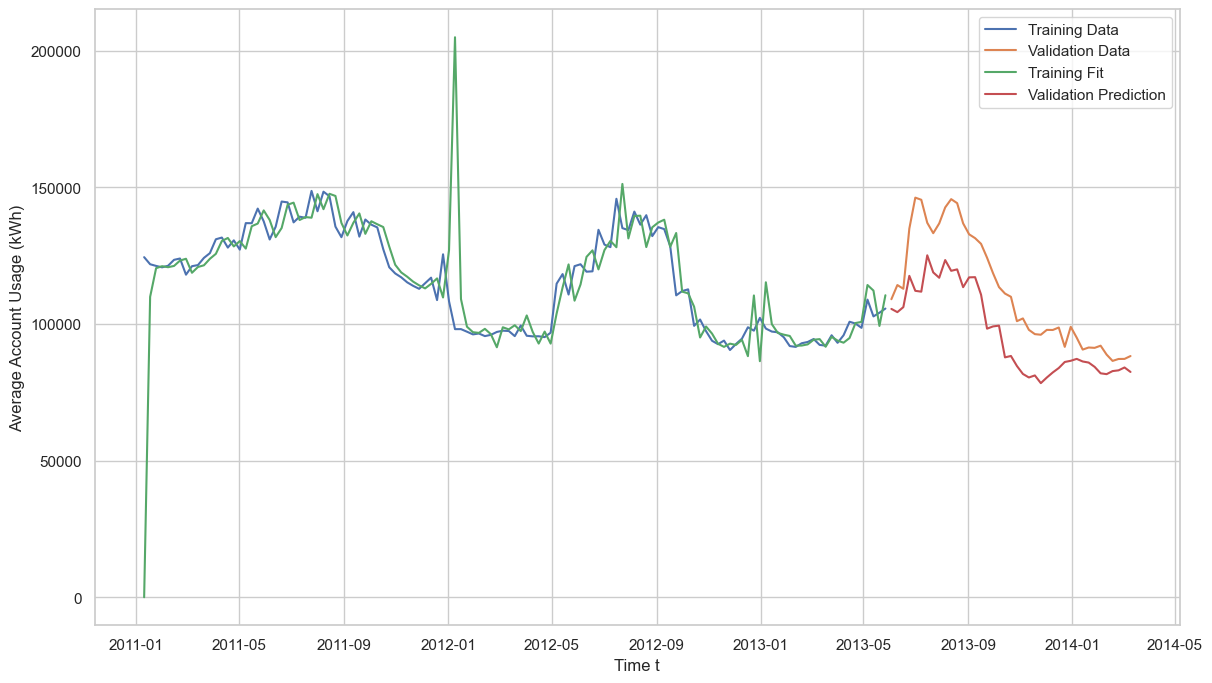

In [6]:
# Validation set - SARIMA with chosen parameters
train, valid, fit, predictions = walk_forward_validation_sarimax( 
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    0, 1, 1, 0, 1, 1, 52,
    type = 'valid')

plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [67]:
account_numbers = [] # track the account number
account_train = [] # training set
account_fit = [] # fit set
account_test_1 = [] # test sets 1-3
account_test_2 = []
account_test_3 = []
account_prediction_1 = [] # prediction sets 1-3
account_prediction_2 = []
account_prediction_3 = []
account_mape_1 = [] # MAPE 1-3
account_mape_2 = []
account_mape_3 = []
account_errors = []
for account_number in tqdm(weekly_usage.account.unique()):
    try:
        df_account = create_kwh_dataframe(weekly_usage[weekly_usage.account == account_number]).drop(columns = ['account'])
        train, tests, fit, predictions = walk_forward_validation_sarimax(
            df_account,
            round(len(df_account)*0.20),
            round(len(df_account)*0.20),
            0, 1, 1, 0, 1, 1, 52,
            type = 'test')
        account_numbers.append(account_number)
        account_train.append(train) # one df
        account_fit.append(fit) # one df
        account_test_1.append(tests[0]) # one of three dfs
        account_test_2.append(tests[1])
        account_test_3.append(tests[2]) 
        account_prediction_1.append(predictions[0]) # one of three dfs
        account_prediction_2.append(predictions[1])
        account_prediction_3.append(predictions[2])
        account_mape_1.append(MAPE(tests[0].value.values, predictions[0].values)) # one of three dfs
        account_mape_2.append(MAPE(tests[1].value.values, predictions[1].values)) 
        account_mape_3.append(MAPE(tests[2].value.values, predictions[2].values)) 
    except:
        account_errors.append(account_number)
        continue
account_results = pd.DataFrame({ # Create DataFrame for results
    'account_numbers' : account_numbers,
    'account_train' : account_train,
    'account_fit' : account_fit,
    'account_test_1' : account_test_1,
    'account_test_2' : account_test_2,
    'account_test_3' : account_test_3,
    'account_prediction_1' : account_prediction_1,
    'account_prediction_2' : account_prediction_2,
    'account_prediction_3' : account_prediction_3,
    'account_mape_1' : account_mape_1,
    'account_mape_2' : account_mape_2,
    'account_mape_3' : account_mape_3
})
#account_results.to_json('sarimax_011_account_results.json') # save to JSON

100%|██████████| 370/370 [30:13<00:00,  4.90s/it]


Text(0.5, 1.0, 'MAPE Results by Account: Chosen Parameters SARIMA')

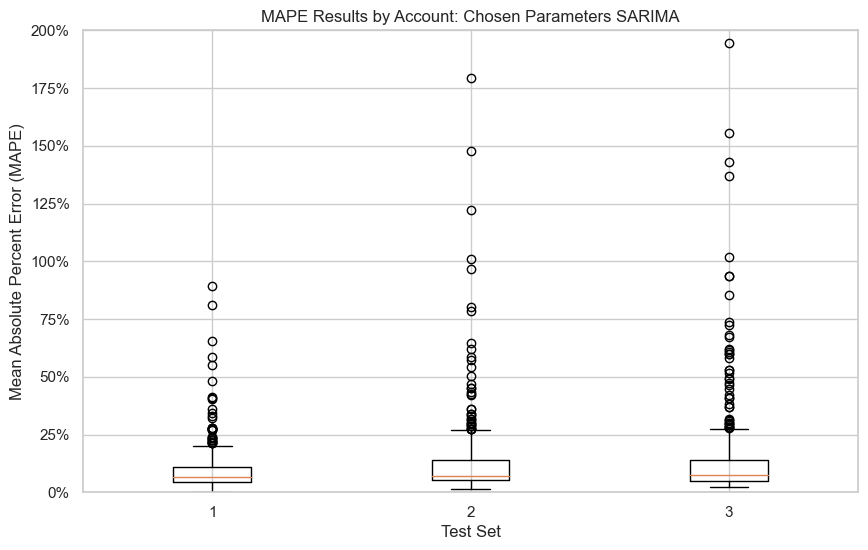

In [74]:
plt.figure(figsize = (10, 6)) # create MAPE boxplots for each test set
plt.boxplot([
    account_results['account_mape_1'].values,
    account_results['account_mape_2'].values,
    account_results['account_mape_3'].values
])
import matplotlib.ticker as mtick
plt.ylim([0, 2])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.xlabel('Test Set')
plt.ylabel('Mean Absolute Percent Error (MAPE)')
plt.title('MAPE Results by Account: Chosen Parameters SARIMA')

In [69]:
account_results[['account_mape_1', 'account_mape_2', 'account_mape_3']].median()

account_mape_1    0.065011
account_mape_2    0.070373
account_mape_3    0.076452
dtype: float64

In [ ]:
#######################################################
# SARIMA regression by account - hyperparameter tuned #
#######################################################

In [ ]:
# Hyperparameter tuning on overall data
best_p, best_d, best_q = np.nan, np.nan, np.nan
best_mape = 1e9
for p in [0, 1, 2]:
    for d in [0, 1, 2]:
        for q in [0, 1, 2]:
            train, valid, fit, predictions = train, test_sets, fit, test_predictions = walk_forward_validation_sarimax( # try to fit one validation set with a vanilla SARIMAX
                weekly_overall,
                round(len(weekly_overall)*0.2),
                round(len(weekly_overall)*0.2), 
                p, d, q, p, d, q, 52,
                type = 'valid')
            current_mape =  MAPE(valid.value.values, predictions.values)
            print('p={}, d={}, q={}, MAPE={}'.format(p, d, q, current_mape))
            if current_mape < best_mape:
                best_mape = current_mape
                best_p, best_d, best_q = p, d, q
# Result: Optimal p=1, d=2, q=1 with MAPE = 10.4%

p=0, d=0, q=0, MAPE=1.0
p=0, d=0, q=1, MAPE=0.6383864520169075


KeyboardInterrupt: 

MAPE = 10.43%


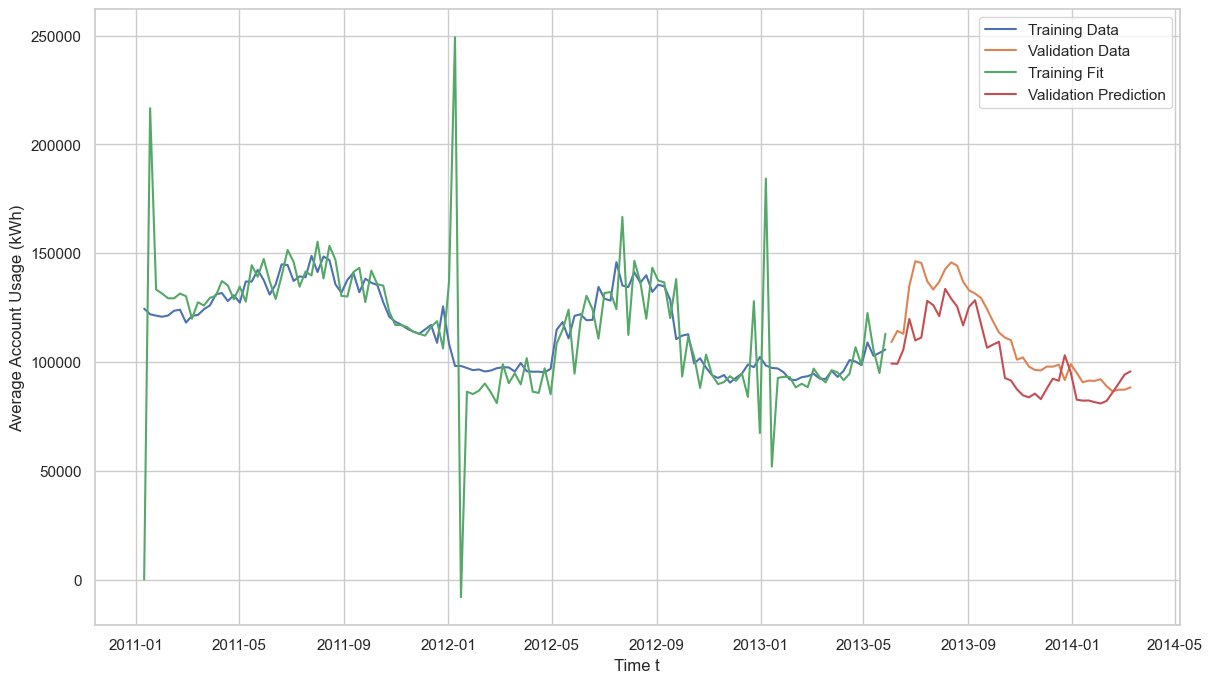

In [ ]:
# Validation set on all data with best hyperparameters
best_p, best_d, best_q = 1, 2, 1
train, valid, fit, predictions = walk_forward_validation_sarimax( # try to fit one validation set with a vanilla SARIMAX
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    best_p, best_d, best_q, best_p, best_d, best_q, 52,
    type = 'valid')

plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [7]:
account_numbers = [] # track the account number
account_train = [] # training set
account_fit = [] # fit set
account_test_1 = [] # test sets 1-3
account_test_2 = []
account_test_3 = []
account_prediction_1 = [] # prediction sets 1-3
account_prediction_2 = []
account_prediction_3 = []
account_mape_1 = [] # MAPE 1-3
account_mape_2 = []
account_mape_3 = []
account_errors = []
for account_number in tqdm(weekly_usage.account.unique()):
    try:
        df_account = create_kwh_dataframe(weekly_usage[weekly_usage.account == account_number]).drop(columns = ['account'])
        train, tests, fit, predictions = walk_forward_validation_sarimax(
            df_account,
            round(len(df_account)*0.20),
            round(len(df_account)*0.20),
            best_p, best_d, best_q, best_p, best_d, best_q, 52,
            type = 'test')
        account_numbers.append(account_number)
        account_train.append(train) # one df
        account_fit.append(fit) # one df
        account_test_1.append(tests[0]) # one of three dfs
        account_test_2.append(tests[1])
        account_test_3.append(tests[2]) 
        account_prediction_1.append(predictions[0]) # one of three dfs
        account_prediction_2.append(predictions[1])
        account_prediction_3.append(predictions[2])
        account_mape_1.append(MAPE(tests[0].value.values, predictions[0].values)) # one of three dfs
        account_mape_2.append(MAPE(tests[1].value.values, predictions[1].values)) 
        account_mape_3.append(MAPE(tests[2].value.values, predictions[2].values)) 
    except:
        account_errors.append(account_number)
        continue
account_results = pd.DataFrame({ # Create DataFrame for results
    'account_numbers' : account_numbers,
    'account_train' : account_train,
    'account_fit' : account_fit,
    'account_test_1' : account_test_1,
    'account_test_2' : account_test_2,
    'account_test_3' : account_test_3,
    'account_prediction_1' : account_prediction_1,
    'account_prediction_2' : account_prediction_2,
    'account_prediction_3' : account_prediction_3,
    'account_mape_1' : account_mape_1,
    'account_mape_2' : account_mape_2,
    'account_mape_3' : account_mape_3
})
#account_results.to_json('sarimax_hp_account_results.json') # save to JSON

100%|██████████| 370/370 [14:14:36<00:00, 138.58s/it]   


Text(0.5, 1.0, 'MAPE Results by Account: Hyperparameter-Tuned SARIMA')

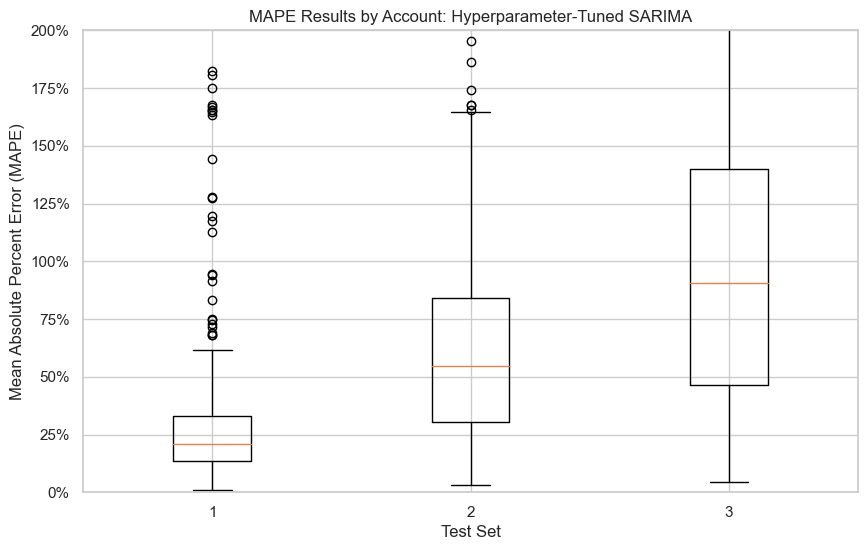

In [39]:
plt.figure(figsize = (10, 6)) # create MAPE boxplots for each test set
plt.boxplot([
    account_results['account_mape_1'].values,
    account_results['account_mape_2'].values,
    account_results['account_mape_3'].values
])
import matplotlib.ticker as mtick
plt.ylim([0, 2])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.xlabel('Test Set')
plt.ylabel('Mean Absolute Percent Error (MAPE)')
plt.title('MAPE Results by Account: Hyperparameter-Tuned SARIMA')

In [66]:
account_results[['account_mape_1', 'account_mape_2', 'account_mape_3']].median()

account_mape_1    0.210830
account_mape_2    0.547578
account_mape_3    0.906022
dtype: float64

In [7]:
########################################################
# FB Prophet regression by account - chosen parameters #
########################################################

19:56:06 - cmdstanpy - INFO - Chain [1] start processing
19:56:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 18.92%


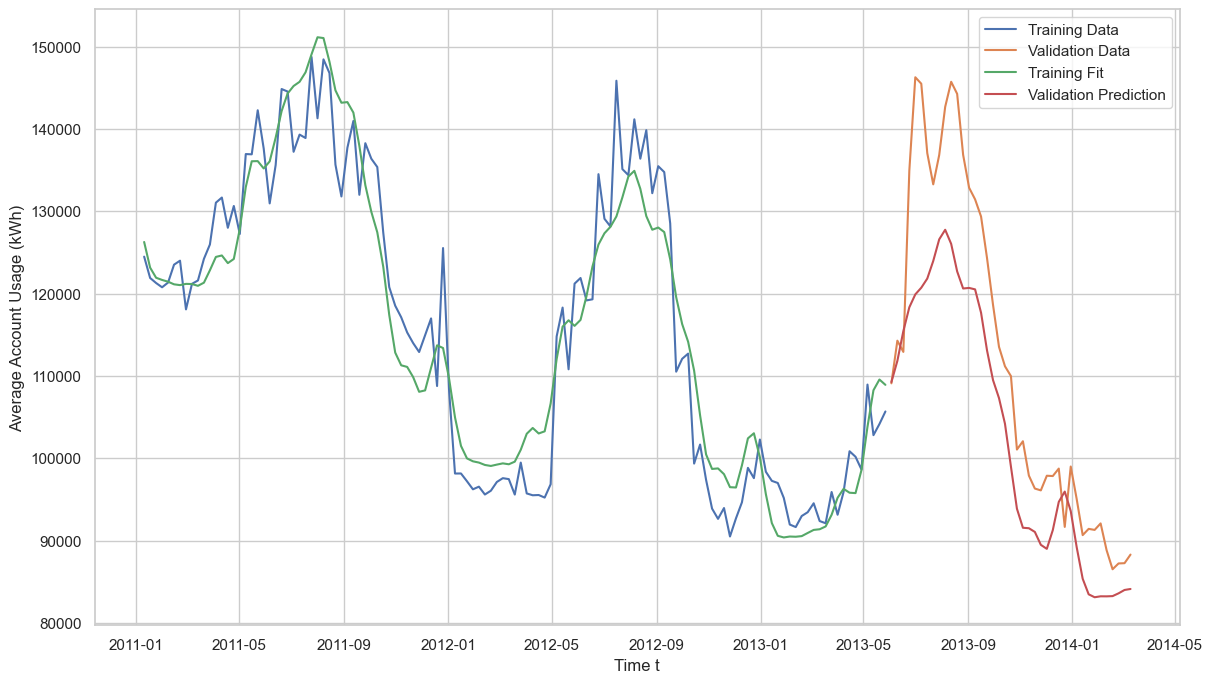

In [8]:
# Initial Validation set for FB Prophet Model
train, valid, fit, predictions = walk_forward_validation_prophet( # try to fit one validation set with FB Prophet
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    type = 'valid',
    period = 365.25,
    fourier_order = 12,
    monthly = False
    )

plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [11]:
account_numbers = [] # track the account number
account_train = [] # training set
account_fit = [] # fit set
account_test_1 = [] # test sets 1-3
account_test_2 = []
account_test_3 = []
account_prediction_1 = [] # prediction sets 1-3
account_prediction_2 = []
account_prediction_3 = []
account_mape_1 = [] # MAPE 1-3
account_mape_2 = []
account_mape_3 = []
account_errors = []
for account_number in tqdm(weekly_usage.account.unique()):
    try:
        df_account = create_kwh_dataframe(weekly_usage[weekly_usage.account == account_number]).drop(columns = ['account'])
        train, tests, fit, predictions = walk_forward_validation_prophet( # fit FB prophet
            df_account,
            round(len(df_account)*0.2),
            round(len(df_account)*0.2), 
            type = 'test',
            period = 365.25,
            fourier_order = 12,
            monthly = False
            )
        account_numbers.append(account_number)
        account_train.append(train) # one df
        account_fit.append(fit) # one df
        account_test_1.append(tests[0]) # one of three dfs
        account_test_2.append(tests[1])
        account_test_3.append(tests[2]) 
        account_prediction_1.append(predictions[0]) # one of three dfs
        account_prediction_2.append(predictions[1])
        account_prediction_3.append(predictions[2])
        account_mape_1.append(MAPE(tests[0].value.values, predictions[0].values)) # one of three dfs
        account_mape_2.append(MAPE(tests[1].value.values, predictions[1].values)) 
        account_mape_3.append(MAPE(tests[2].value.values, predictions[2].values)) 
    except:
        account_errors.append(account_number)
        continue
account_results = pd.DataFrame({ # Create DataFrame for results
    'account_numbers' : account_numbers,
    'account_train' : account_train,
    'account_fit' : account_fit,
    'account_test_1' : account_test_1,
    'account_test_2' : account_test_2,
    'account_test_3' : account_test_3,
    'account_prediction_1' : account_prediction_1,
    'account_prediction_2' : account_prediction_2,
    'account_prediction_3' : account_prediction_3,
    'account_mape_1' : account_mape_1,
    'account_mape_2' : account_mape_2,
    'account_mape_3' : account_mape_3
})
#account_results.to_json('fbp_account_results.json') # save to JSON

  0%|          | 0/370 [00:00<?, ?it/s]19:56:31 - cmdstanpy - INFO - Chain [1] start processing
19:56:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/370 [00:00<01:13,  5.02it/s]19:56:31 - cmdstanpy - INFO - Chain [1] start processing
19:56:31 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/370 [00:00<01:14,  4.95it/s]19:56:31 - cmdstanpy - INFO - Chain [1] start processing
19:56:31 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 3/370 [00:00<01:13,  5.00it/s]19:56:31 - cmdstanpy - INFO - Chain [1] start processing
19:56:31 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/370 [00:00<01:14,  4.94it/s]19:56:32 - cmdstanpy - INFO - Chain [1] start processing
19:56:32 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 5/370 [00:01<01:13,  5.00it/s]19:56:32 - cmdstanpy - INFO - Chain [1] start processing
19:56:32 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 6/370 [00:01<01:13,  4.98it/s]1

Text(0.5, 1.0, 'MAPE Results by Account: Hyperparameter-Tuned SARIMA')

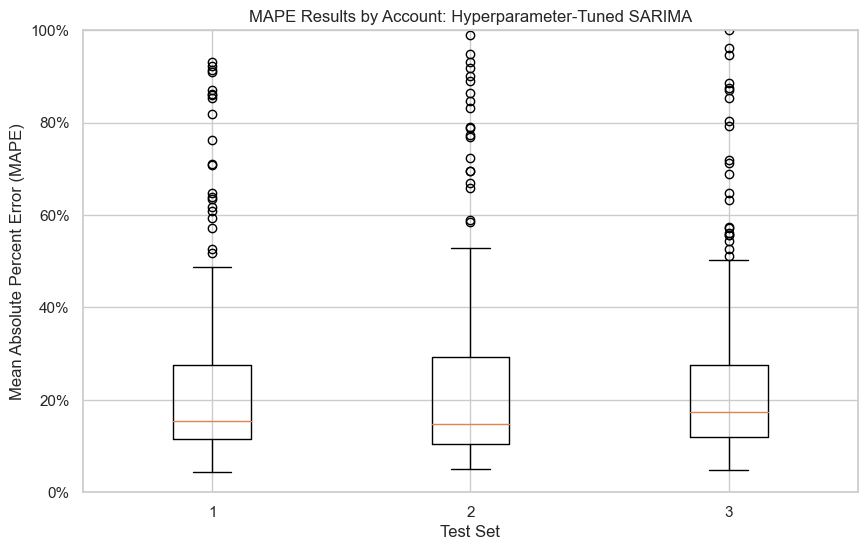

In [15]:
plt.figure(figsize = (10, 6)) # create MAPE boxplots for each test set
plt.boxplot([
    account_results['account_mape_1'].values,
    account_results['account_mape_2'].values,
    account_results['account_mape_3'].values
])
import matplotlib.ticker as mtick
plt.ylim([0, 1])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.xlabel('Test Set')
plt.ylabel('Mean Absolute Percent Error (MAPE)')
plt.title('MAPE Results by Account: FB Prophet Chosen Parameters')

In [16]:
account_results[['account_mape_1', 'account_mape_2', 'account_mape_3']].median()

account_mape_1    0.154988
account_mape_2    0.147900
account_mape_3    0.173508
dtype: float64

In [ ]:
########################################################################
# FB Prophet regression by account - hyperparameter tuning per account #
########################################################################

In [5]:
account_numbers = [] # track the account number
account_train = [] # training set
account_fit = [] # fit set
account_test_1 = [] # test sets 1-3
account_test_2 = []
account_test_3 = []
account_prediction_1 = [] # prediction sets 1-3
account_prediction_2 = []
account_prediction_3 = []
account_mape_1 = [] # MAPE 1-3
account_mape_2 = []
account_mape_3 = []
account_errors = []
for account_number in tqdm(weekly_usage.account.unique()):
    try:
        df_account = create_kwh_dataframe(weekly_usage[weekly_usage.account == account_number]).drop(columns = ['account'])

        ################################################################################
        # Validation set on all data with best hyperparameters
        best_monthly = np.nan
        best_fourier_order = np.nan
        best_mape = 1e9
        for monthly in [True, False]:
            for fourier_order in [6, 12]:
                train, valid, fit, predictions = walk_forward_validation_prophet(
                    df_account,
                    round(len(df_account)*0.2),
                    round(len(df_account)*0.2), 
                    type = 'valid',
                    period = 366,
                    fourier_order = fourier_order,
                    monthly = monthly
                    );
                mape = MAPE(valid.value.values, predictions.values)
                if mape<best_mape:
                    best_mape = mape
                    best_fourier_order = fourier_order
                    best_monthly = monthly
    ####################################################################################

        train, tests, fit, predictions = walk_forward_validation_prophet( # fit FB prophet
            df_account,
            round(len(df_account)*0.2),
            round(len(df_account)*0.2), 
            type = 'test',
            period = 366,
            fourier_order = best_fourier_order,
            monthly = best_monthly
            )
        account_numbers.append(account_number)
        account_train.append(train) # one df
        account_fit.append(fit) # one df
        account_test_1.append(tests[0]) # one of three dfs
        account_test_2.append(tests[1])
        account_test_3.append(tests[2]) 
        account_prediction_1.append(predictions[0]) # one of three dfs
        account_prediction_2.append(predictions[1])
        account_prediction_3.append(predictions[2])
        account_mape_1.append(MAPE(tests[0].value.values, predictions[0].values)) # one of three dfs
        account_mape_2.append(MAPE(tests[1].value.values, predictions[1].values)) 
        account_mape_3.append(MAPE(tests[2].value.values, predictions[2].values)) 
    except:
        account_errors.append(account_number)
        continue
account_results = pd.DataFrame({ # Create DataFrame for results
    'account_numbers' : account_numbers,
    'account_train' : account_train,
    'account_fit' : account_fit,
    'account_test_1' : account_test_1,
    'account_test_2' : account_test_2,
    'account_test_3' : account_test_3,
    'account_prediction_1' : account_prediction_1,
    'account_prediction_2' : account_prediction_2,
    'account_prediction_3' : account_prediction_3,
    'account_mape_1' : account_mape_1,
    'account_mape_2' : account_mape_2,
    'account_mape_3' : account_mape_3
})
#account_results.to_json('fbp_hp_account_results.json') # save to JSON

  0%|          | 0/370 [00:00<?, ?it/s]22:30:17 - cmdstanpy - INFO - Chain [1] start processing
22:30:18 - cmdstanpy - INFO - Chain [1] done processing
22:30:18 - cmdstanpy - INFO - Chain [1] start processing
22:30:20 - cmdstanpy - INFO - Chain [1] done processing
22:30:20 - cmdstanpy - INFO - Chain [1] start processing
22:30:20 - cmdstanpy - INFO - Chain [1] done processing
22:30:20 - cmdstanpy - INFO - Chain [1] start processing
22:30:20 - cmdstanpy - INFO - Chain [1] done processing
22:30:20 - cmdstanpy - INFO - Chain [1] start processing
22:30:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/370 [00:03<20:44,  3.37s/it]22:30:21 - cmdstanpy - INFO - Chain [1] start processing
22:30:22 - cmdstanpy - INFO - Chain [1] done processing
22:30:22 - cmdstanpy - INFO - Chain [1] start processing
22:30:24 - cmdstanpy - INFO - Chain [1] done processing
22:30:24 - cmdstanpy - INFO - Chain [1] start processing
22:30:24 - cmdstanpy - INFO - Chain [1] done processing
22:30:24 -

Text(0.5, 1.0, 'MAPE Results by Account: Hyperparameter-Tuned SARIMA')

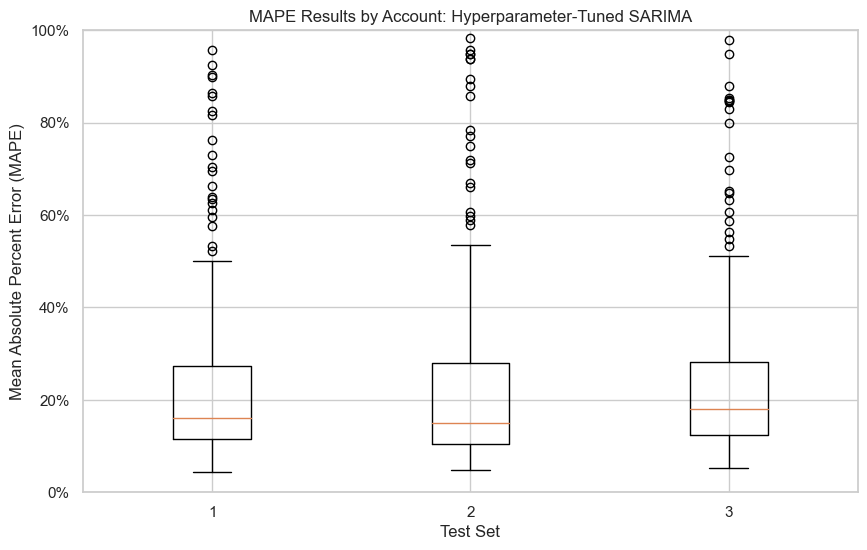

In [6]:
plt.figure(figsize = (10, 6)) # create MAPE boxplots for each test set
plt.boxplot([
    account_results['account_mape_1'].values,
    account_results['account_mape_2'].values,
    account_results['account_mape_3'].values
])
import matplotlib.ticker as mtick
plt.ylim([0, 1])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.xlabel('Test Set')
plt.ylabel('Mean Absolute Percent Error (MAPE)')
plt.title('MAPE Results by Account: Hyperparameter-Tuned FB Prophet')

In [7]:
account_results[['account_mape_1', 'account_mape_2', 'account_mape_3']].median()

account_mape_1    0.160205
account_mape_2    0.149159
account_mape_3    0.181130
dtype: float64

In [ ]:
##############################################
# FB Propet hyperparameter tuned per account #
##############################################

21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1]

MAPE = 18.79%


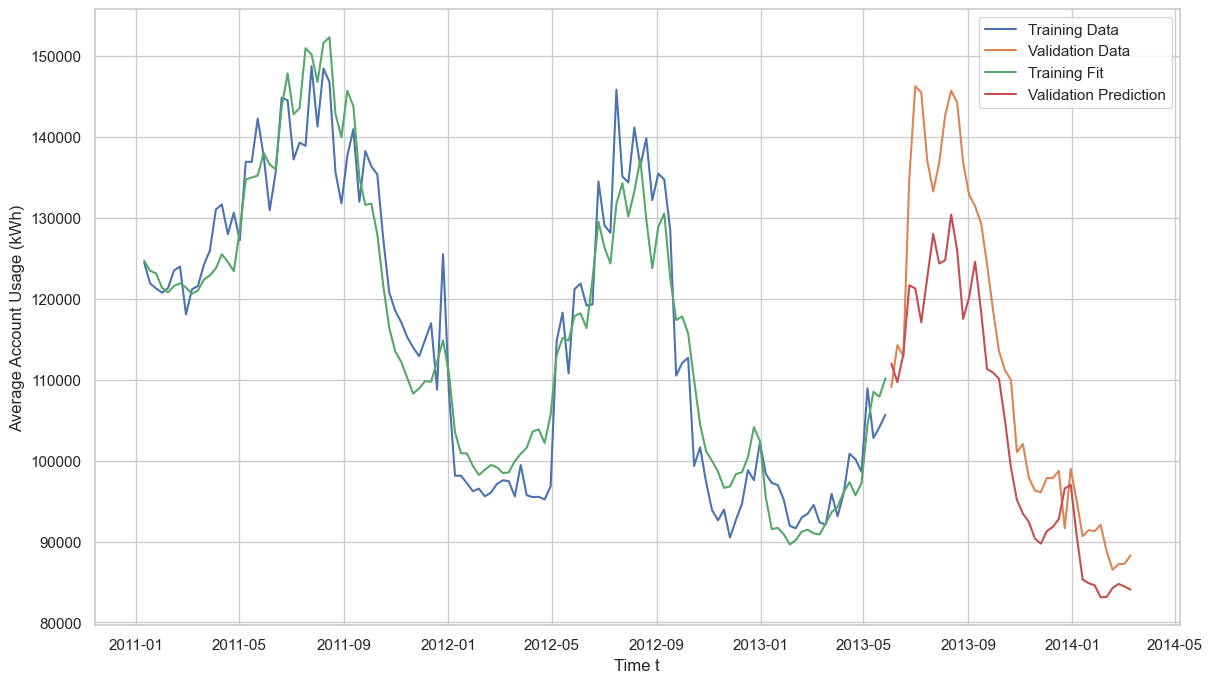

In [5]:
# Validation set on all data with best hyperparameters
best_period = np.nan
best_monthly = np.nan
best_fourier_order = np.nan
best_mape = 1e9
for period in [364, 365, 365.25, 366]:
    for monthly in [True, False]:
        for fourier_order in np.arange(6, 20, 2):
            train, valid, fit, predictions = walk_forward_validation_prophet(
                weekly_overall,
                round(len(weekly_overall)*0.2),
                round(len(weekly_overall)*0.2), 
                type = 'valid',
                period = period,
                fourier_order = fourier_order,
                monthly = monthly
                )
            mape = MAPE(valid.value.values, predictions.values)
            if mape<best_mape:
                best_mape = mape
                best_period = period
                best_fourier_order = fourier_order
                best_monthly = monthly
best_period, best_fourier_order, best_monthly, best_mape

# Initial Validation set for FB Prophet Model
train, valid, fit, predictions = walk_forward_validation_prophet( # try to fit one validation set with a vanilla SARIMAX
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    type = 'valid',
    period = best_period,
    fourier_order = best_fourier_order,
    monthly = best_monthly
    )

plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [8]:
account_results[['account_mape_1', 'account_mape_2', 'account_mape_3']].median()

account_mape_1    0.160205
account_mape_2    0.149159
account_mape_3    0.181130
dtype: float64